# Methods

Starting a new notebook to address many of the thoughts in this comment: https://github.com/ocean-transport/argo-intern/issues/10#issuecomment-1574128413. 

This will likely include work to address:
- different ways to deal with boundaries when filtering
- a closer look into spice anomaly

In [15]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload

import filt_funcs as ff
import EV_funcs as ef
import plot_funcs as pf
import density_funcs as df
import funcs

In [9]:
reload(ff)
reload(ef)
reload(pf)
reload(df)
reload(funcs)

<module 'funcs' from '/home.ufs/amf2288/argo-intern/funcs.py'>

### Idealized Profiles

This example is from Dhruv's notebooks over winter break (and more specifically the density-spice notebook).

In [10]:
L = 1000 # let's say units of m 
N = 512

alpha = 0
N2, z, dz = funcs.random_phase_power_law_function(alpha, N, L)
S, z, dz  = funcs.random_phase_power_law_function(3, N, L)
S = S/S.std()+36.5
N2 = (N2 + N2.max()+1) * 2e-4
rho = np.cumsum(N2) + 1020

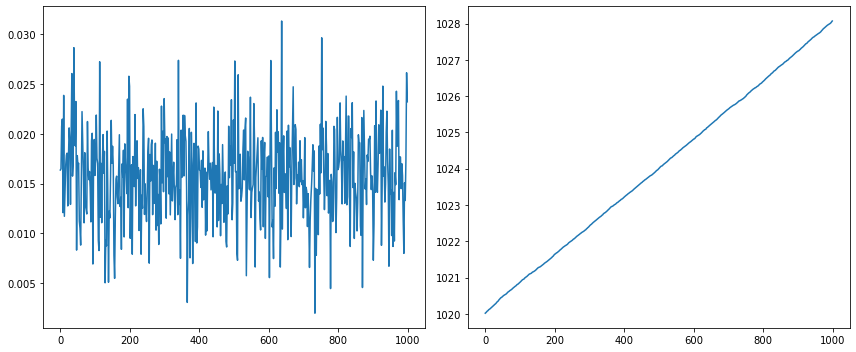

In [13]:
plt.figure(figsize= (12, 5))
plt.subplot(121)
plt.plot(z, N2)

plt.subplot(122)
plt.plot(z, rho)

plt.tight_layout()

In [16]:
T, _ = gsw.CT_from_rho(rho, S, 0)

spice = gsw.spiciness0(S, T)

In [33]:
profile = xr.Dataset(data_vars=dict(
                        CT=(['depth'],T),
                        SA=(['depth'],S),
                        SIG=(['depth'],rho),
                        SPICE=(['depth'], spice)
                        ),
                    coords=dict(
                        depth=z)
                        )

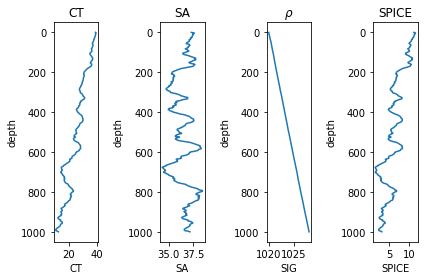

In [36]:
plt.subplot(141)
profile.CT.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('CT')

plt.subplot(142)
profile.SA.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SA')

plt.subplot(143)
profile.SIG.plot(y='depth')
plt.gca().invert_yaxis()
plt.title(r'$\rho$')

plt.subplot(144)
profile.SPICE.plot(y='depth')
plt.gca().invert_yaxis()
plt.title('SPICE')


plt.tight_layout()

### Boundaries

A few different approaches are possible here, a few of them are noted below:
- filter the whole profile
- filter the whole profile, then mask both boundaries (based on the filter scale)
- filter the whole profile, then mask the upper boundary (based on the mixed layer depth)
- select the profile below the mixed layer, then filter

First up, I'll need to get a handle on mixed layer datasets. Looking at the netcdf file with MLD for every argo profile here: http://mixedlayer.ucsd.edu/. It's a large file though (300+MB) so I have to figure out the best way to upload it here.